<a href="https://colab.research.google.com/github/mosdragon/kdd2020/blob/master/tutorial/Colab-Chapter3_4/Training_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# KDD2020 Tutorial - Computer Vision: Deep Dive into Object Segmentation Approaches - Chapters 3 & 4

Welcome to the Colab version of Chapter 3-4 of our tutorial! This is a modified version of the official colab tutorial for using MMDetection. In this tutorial, you will learn
- Perform segmentation inference with a MMDet detector.
- Train a new segmentation model detector with a new customized dataset.
- Model inference and Image Post-Processing

Let's start!


## Install MMDetection

In [5]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [6]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5.1+cu101 torchvision==0.6.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html

# install mmcv-full thus we could use CUDA operators
!pip install mmcv-full==1.0.5

# Install mmdetection
!rm -rf mmdetection
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection

!pip install -e .

# install Pillow 7.0.0 back in order to avoid bug in colab
!pip install Pillow==7.0.0

Looking in links: https://download.pytorch.org/whl/torch_stable.html
Requirement already up-to-date: torch==1.5.1+cu101 in /usr/local/lib/python3.6/dist-packages (1.5.1+cu101)
Requirement already up-to-date: torchvision==0.6.1+cu101 in /usr/local/lib/python3.6/dist-packages (0.6.1+cu101)
Cloning into 'mmdetection'...
remote: Enumerating objects: 1, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 12666 (delta 0), reused 0 (delta 0), pack-reused 12665
Receiving objects: 100% (12666/12666), 13.54 MiB | 30.48 MiB/s, done.
Resolving deltas: 100% (8518/8518), done.
/content/mmdetection/mmdetection
Obtaining file:///content/mmdetection/mmdetection
  Found existing installation: mmdet 2.3.0
    Can't uninstall 'mmdet'. No files were found to uninstall.
  Running setup.py develop for mmdet


In [7]:
# Due to an existing issue, pycocotools must be installed directly from github source
!pip install -U "git+https://github.com/open-mmlab/cocoapi.git#subdirectory=pycocotools"

  Cloning https://github.com/open-mmlab/cocoapi.git to /tmp/pip-req-build-otgzkopa
  Running command git clone -q https://github.com/open-mmlab/cocoapi.git /tmp/pip-req-build-otgzkopa
  Created wheel for pycocotools: filename=pycocotools-12.0-cp36-cp36m-linux_x86_64.whl size=266736 sha256=a953c776cd8e1177a017410cd93adb3e08bd8c435959c341b37038ad12651d15
  Stored in directory: /tmp/pip-ephem-wheel-cache-4zowpcs3/wheels/cd/f6/de/018ccc2d175046c612e93b42a169cd1ab7563d61581cfba8df
Successfully built pycocotools
  Found existing installation: pycocotools 12.0
    Uninstalling pycocotools-12.0:
      Successfully uninstalled pycocotools-12.0


In [8]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

1.5.1+cu101 True
2.3.0
10.1
GCC 7.5


## Perform inference with a MMDet segmentation (Mask-R-CNN) detector.
MMDetection already provides high level APIs to do inference and training.

In [9]:
!mkdir checkpoints
!wget -c https://open-mmlab.s3.ap-northeast-2.amazonaws.com/mmdetection/v2.0/res2net/mask_rcnn_r2_101_fpn_2x_coco/mask_rcnn_r2_101_fpn_2x_coco-17f061e8.pth \
      -O checkpoints/mask_rcnn_r2_101_fpn_2x_coco-17f061e8.pth

--2020-08-19 19:43:33--  https://open-mmlab.s3.ap-northeast-2.amazonaws.com/mmdetection/v2.0/res2net/mask_rcnn_r2_101_fpn_2x_coco/mask_rcnn_r2_101_fpn_2x_coco-17f061e8.pth
Resolving open-mmlab.s3.ap-northeast-2.amazonaws.com (open-mmlab.s3.ap-northeast-2.amazonaws.com)... 52.219.56.59
Connecting to open-mmlab.s3.ap-northeast-2.amazonaws.com (open-mmlab.s3.ap-northeast-2.amazonaws.com)|52.219.56.59|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 256924178 (245M) [application/x-www-form-urlencoded]
Saving to: ‘checkpoints/mask_rcnn_r2_101_fpn_2x_coco-17f061e8.pth’

checkpoints/mask_rc 100%[===================>] 245.02M  24.6MB/s    in 11s     

2020-08-19 19:43:45 (22.5 MB/s) - ‘checkpoints/mask_rcnn_r2_101_fpn_2x_coco-17f061e8.pth’ saved [256924178/256924178]



In [10]:
from mmdet.apis import inference_detector, init_detector, show_result_pyplot

# Choose to use a config and initialize the detector
config = 'configs/res2net/mask_rcnn_r2_101_fpn_2x_coco.py'
# Setup a checkpoint file to load
checkpoint = 'checkpoints/mask_rcnn_r2_101_fpn_2x_coco-17f061e8.pth'
# initialize the detector
model = init_detector(config, checkpoint, device='cuda:0')

In [11]:
# Use the detector to do inference
img = 'demo/demo.jpg'
result = inference_detector(model, img)

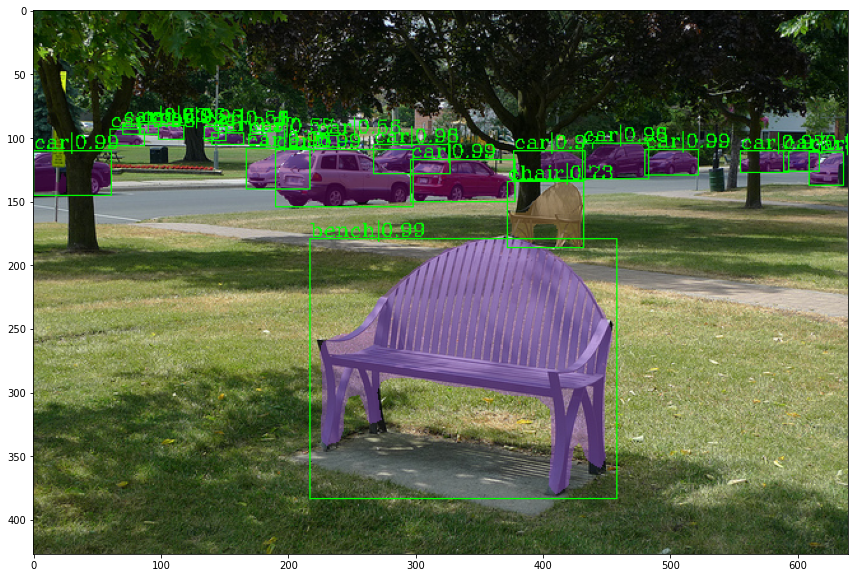

In [12]:
# Let's plot the result
show_result_pyplot(model, img, result, score_thr=0.5)

## Train a new segmentation model on a customized dataset

To train a new detector, there are usually three things to do:
1. Support a new dataset (our subset of ADE20K)
2. Modify the config
3. Train a new model



### Support a new dataset

There are three ways to support a new dataset in MMDetection: 
  1. reorganize the dataset into COCO format.
  2. reorganize the dataset into a middle format.
  3. implement a new dataset.

Usually we recommend to use the first two methods which are usually easier than the third.

In chapter 2 of this tutorial , we offered an example to convert both ADE20K data and LabelMe-generated custom data into the format of existing datasets like COCO, VOC, etc. Other methods and more advanced usages can be found in the [doc](https://mmdetection.readthedocs.io/en/latest/tutorials/new_dataset.html#).

We will download the re-formatted dataset from our link and visualize the data first.

In [13]:
# download, decompress the data
!wget https://storage.googleapis.com/kdd2020hdvisai/static/datasets/bedroom_scenes_coco_final.zip -O kdd_final.zip
!unzip kdd_final.zip > /dev/null

--2020-08-19 19:43:59--  https://storage.googleapis.com/kdd2020hdvisai/static/datasets/bedroom_scenes_coco_final.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.197.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 307198459 (293M) [application/zip]
Saving to: ‘kdd_final.zip’

kdd_final.zip       100%[===================>] 292.97M  91.1MB/s    in 3.2s    

2020-08-19 19:44:02 (91.1 MB/s) - ‘kdd_final.zip’ saved [307198459/307198459]



In [14]:
# Check the directory structure of the tiny data
# Install tree first
!apt-get -q install tree
!tree bedroom_scenes_coco/

Reading package lists...
Building dependency tree...
Reading state information...
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 0s (81.9 kB/s)
Selecting previously unselected package tree.
(Reading database ... 144487 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
bedroom_scenes_coco/
├── annotations
│   ├── instances_train2014.json
│   └── instances_val2014.json
├── train2014
│   ├── 0.jpg
│   ├── 1000.jpg
│   ├── 1001

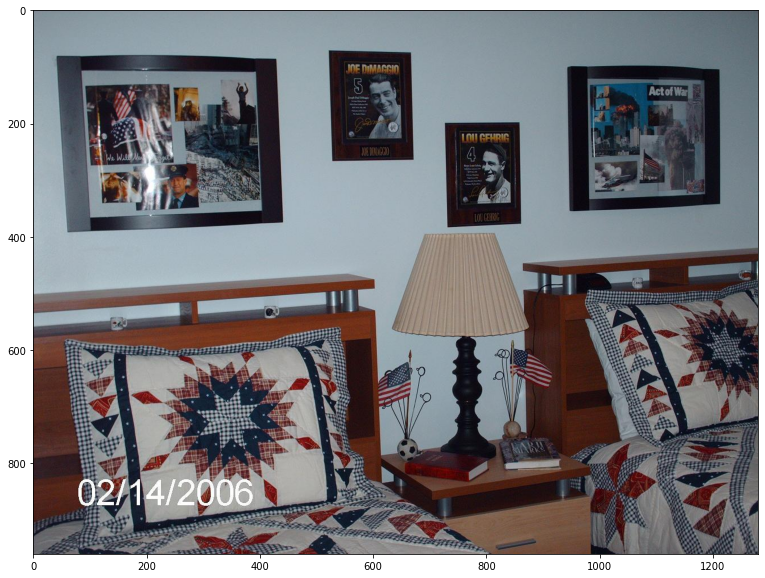

In [15]:
# Let's take a look at the dataset image
import mmcv
import matplotlib.pyplot as plt

img = mmcv.imread('bedroom_scenes_coco/train2014/0.jpg')
plt.figure(figsize=(15, 10))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

After downloading the data, we implemented **`Ade20kBed`** based on the CocoDataset.

Let's take a loot at the annotation txt file.



In [16]:
import copy
import os.path as osp

import mmcv
import numpy as np


from mmdet.datasets.coco import CocoDataset
from mmdet.datasets.builder import DATASETS

@DATASETS.register_module()
class Ade20kBed(CocoDataset):
    CLASSES = ('door | doorframe, doorcase | double door', 'bed | bedpost | blanket, cover | headboard', 
               'wardrobe, closet, press', 'lamp', 'chest of drawers, chest, bureau, dresser | chest', 'pillow', 
               'armchair | chair | swivel    chair', 'pane, pane of glass, window glass | windowpane, window', 
               'curtain, drape, drapery, mantle, pall', 'mirror', 'painting, picture | frame', 'wall', 'ceiling', 
               'floor, flooring', 'cabinet')

### Modify the config

In the next step, we need to modify the config for the training. Please see the non-colab version for example of how to modify config files and train on command line.

In [17]:
from mmcv import Config
cfg = Config.fromfile('./configs/res2net/mask_rcnn_r2_101_fpn_2x_coco.py')

Given a config that trains a Faster R-CNN on COCO dataset, we need to modify some values to use it for training Faster R-CNN on KITTI dataset.

In [18]:
from mmdet.apis import set_random_seed


# # Modify dataset type and path
cfg.data_root = 'bedroom_scenes_coco/'
cfg.dataset_type = 'Ade20kBed'

cfg.data.train.type = 'Ade20kBed'
cfg.data.train.data_root = 'bedroom_scenes_coco/'
cfg.data.train.ann_file = 'annotations/instances_train2014.json'
cfg.data.train.img_prefix = 'train2014/'

cfg.data.val.type = 'Ade20kBed'
cfg.data.val.data_root = 'bedroom_scenes_coco/'
cfg.data.val.ann_file = 'annotations/instances_val2014.json'
cfg.data.val.img_prefix = 'val2014/'

# Here we are not using the test dataset, so we just made a copy to ensure the
# config keys are not missing
cfg.data.test.type = 'Ade20kBed'
cfg.data.test.data_root = 'bedroom_scenes_coco/'
cfg.data.test.ann_file = 'annotations/instances_val2014.json'
cfg.data.test.img_prefix = 'val2014/'

# modify num classes of the model in box head
# cfg.model.roi_head.bbox_head.num_classes = 3
# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
cfg.load_from = 'checkpoints/mask_rcnn_r2_101_fpn_2x_coco-17f061e8.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './tutorial_exps'

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None
cfg.log_config.interval = 10

# Change the evaluation metric since we use customized dataset.
cfg.evaluation.metric = 'mAP'
# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 12
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 12

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)
cfg.total_epochs = 1

# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')


Config:
model = dict(
    type='MaskRCNN',
    pretrained='open-mmlab://res2net101_v1d_26w_4s',
    backbone=dict(
        type='Res2Net',
        depth=101,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        scales=4,
        base_width=26),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmo

### Train a new model

Finally, lets initialize the dataset and model, then train a new model!
Here, we train for only 1 epoch due to time constraint.

In [19]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector


# Build dataset

datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_detector(
    cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg)
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

loading annotations into memory...
Done (t=0.17s)
creating index...
index created!


2020-08-19 19:44:59,672 - mmdet - INFO - load model from: open-mmlab://res2net101_v1d_26w_4s
Downloading: "https://open-mmlab.s3.ap-northeast-2.amazonaws.com/pretrain/third_party/res2net101_v1d_26w_4s_mmdetv2-f0a600f9.pth" to /root/.cache/torch/checkpoints/res2net101_v1d_26w_4s_mmdetv2-f0a600f9.pth


2020-08-19 19:45:08,596 - mmdet - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

2020-08-19 19:45:08,853 - mmdet - INFO - load checkpoint from checkpoints/mask_rcnn_r2_101_fpn_2x_coco-17f061e8.pth


loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


2020-08-19 19:45:09,223 - mmdet - INFO - Start running, host: root@049ae41ca2ff, work_dir: /content/mmdetection/mmdetection/tutorial_exps
2020-08-19 19:45:09,224 - mmdet - INFO - workflow: [('train', 1)], max: 1 epochs
2020-08-19 19:45:22,448 - mmdet - INFO - Epoch [1][10/840]	lr: 2.500e-03, eta: 0:18:16, time: 1.321, data_time: 0.311, memory: 6865, loss_rpn_cls: 0.1204, loss_rpn_bbox: 0.1413, loss_cls: 1.1147, acc: 84.2480, loss_bbox: 0.4235, loss_mask: 0.6276, loss: 2.4275
2020-08-19 19:45:31,989 - mmdet - INFO - Epoch [1][20/840]	lr: 2.500e-03, eta: 0:15:32, time: 0.954, data_time: 0.031, memory: 6865, loss_rpn_cls: 0.0451, loss_rpn_bbox: 0.1207, loss_cls: 0.5546, acc: 88.7793, loss_bbox: 0.3500, loss_mask: 0.5489, loss: 1.6192
2020-08-19 19:45:42,374 - mmdet - INFO - Epoch [1][30/840]	lr: 2.500e-03, eta: 0:14:54, time: 1.039, data_time: 0.040, memory: 6968, loss_rpn_cls: 0.0562, loss_rpn_bbox: 0.1498, loss_cls: 0.5884, acc: 87.4316, loss_bbox: 0.4046, loss_mask: 0.4768, loss: 1.675

### Understand the log
From the log, we can have a basic understanding the training process and know how well the detector is trained. If we train more epochs, we will be able to see the results improve overtime.

## Test the trained model

After finetuning the model, let's visualize the prediction results using an image from our training set!

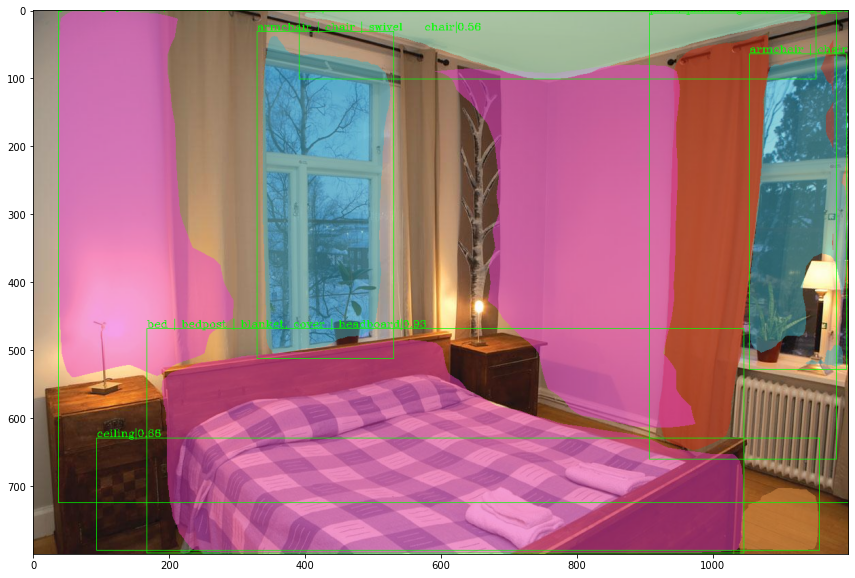

In [24]:
img = mmcv.imread('bedroom_scenes_coco/train2014/1.jpg')

model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result, score_thr=0.5)


## Test the model trained for 18 epochs

Now we provide the same model trained for 18 epochs and visualize the results!

In [21]:
!wget https://storage.googleapis.com/kdd2020hdvisai/static/models/epoch_18.pth -O checkpoints/epoch_18.pth
!wget https://storage.googleapis.com/kdd2020hdvisai/static/models/mask_rcnn_r2_101_fpn_2x_coco.py -O checkpoints/config.py

--2020-08-19 20:05:14--  https://storage.googleapis.com/kdd2020hdvisai/static/models/epoch_18.pth
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 509495436 (486M) [application/octet-stream]
Saving to: ‘checkpoints/epoch_18.pth’

checkpoints/epoch_1 100%[===================>] 485.89M  91.2MB/s    in 5.4s    

2020-08-19 20:05:20 (89.4 MB/s) - ‘checkpoints/epoch_18.pth’ saved [509495436/509495436]

--2020-08-19 20:05:21--  https://storage.googleapis.com/kdd2020hdvisai/static/models/mask_rcnn_r2_101_fpn_2x_coco.py
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 142.250.99.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8886 (

In [22]:
checkpoint_18 = 'checkpoints/epoch_18.pth'
config_18 = 'checkpoints/config.py'
model_final = init_detector(config_18, checkpoint_18, device='cuda:0')
# Add an attribute for visualization convenience
model_final.CLASSES = datasets[0].CLASSES

/usr/local/lib/python3.6/dist-packages/mmcv/utils/misc.py:256: UserWarning: "out_size" is deprecated in `RoIAlign.__init__`, please use "output_size" instead
  f'"{src_arg_name}" is deprecated in '
/usr/local/lib/python3.6/dist-packages/mmcv/utils/misc.py:256: UserWarning: "sample_num" is deprecated in `RoIAlign.__init__`, please use "sampling_ratio" instead
  f'"{src_arg_name}" is deprecated in '


In [23]:
img = 'bedroom_scenes_coco/train2014/1.jpg'
result = inference_detector(model_final, img)

/usr/local/lib/python3.6/dist-packages/mmcv/utils/misc.py:256: UserWarning: "iou_thr" is deprecated in `nms`, please use "iou_threshold" instead
  f'"{src_arg_name}" is deprecated in '


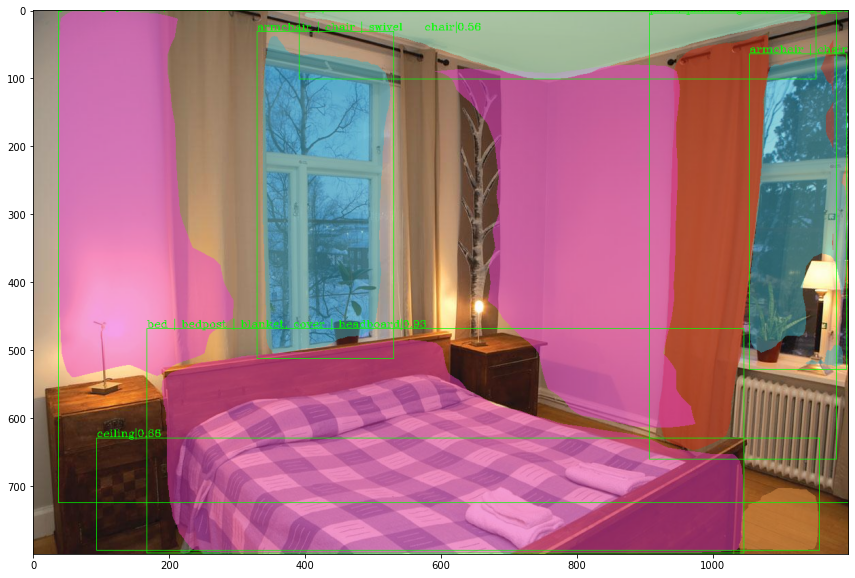

In [25]:
# Let's plot the result
show_result_pyplot(model_final, img, result, score_thr=0.5)

You can see that it performs much better than the model trained for 2 epochs only!

## Model Inference and Image Post-Processing
Now, we will do the following:

* Apply the trained model on new images
* Use classic computer vision techniques such as contour approximation to refine segmentation boundaries


### Load in necessary modules

In [26]:
import imageio
import numpy as np
import matplotlib.pyplot as plt
import cv2

### Define functions for reading image, obtaining segmentation details, and refining results

In [27]:
def read_image(path):
    image = imageio.imread(path)
    return image

In [28]:
def segm_detail(image, result, model, score_thr=0.5, ):
    if isinstance(result, tuple):
        bbox_result, segm_result = result
    else:
        bbox_result, segm_result = result, None
    bboxes = np.vstack(bbox_result)

    labels = [
            np.full(bbox.shape[0], i, dtype=np.int32)
            for i, bbox in enumerate(bbox_result)
        ]

    # bboxes, labels pair contain info for each segmentation, len(bboxes) = len(labels)        
    # label (in the form of integer) indicates the index of the class_names                    
    labels = np.concatenate(labels)                                                            
    return labels, bboxes, segm_result

In [29]:
def getApproxCorner(hull, coef=0.03, corner=4):
    epsilon = coef*cv2.arcLength(hull,True)
    approx = cv2.approxPolyDP(hull,epsilon,True)
    while len(approx) != corner:
        if len(approx) > corner:
            coef += 0.001
            epsilon = coef*cv2.arcLength(hull,True)
            approx = cv2.approxPolyDP(hull,epsilon,True)
        elif len(approx) < corner:
            coef -= 0.001
            epsilon = coef*cv2.arcLength(hull,True)
            approx = cv2.approxPolyDP(hull,epsilon,True)
    assert(len(approx) == corner)
    return approx

### Load model and run inference on example image

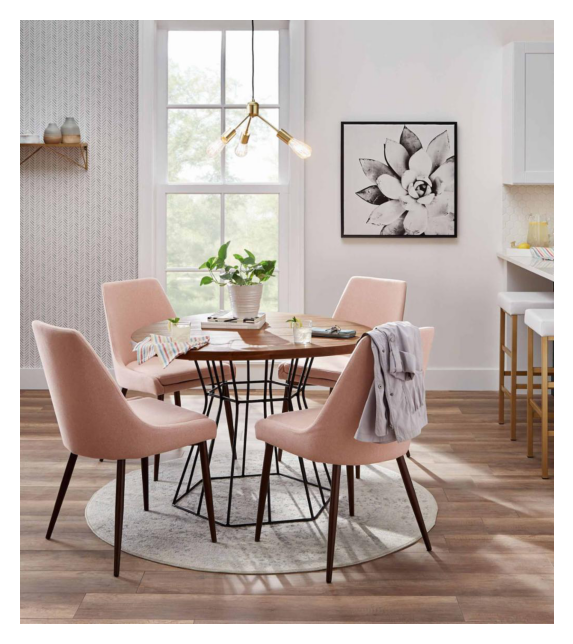

In [30]:
img = read_image('https://images.homedepot-static.com/lifestyleimages/1024x682/c5ace81b-43ea-4428-bb47-a7d528ba7c0211.jpeg')
fig = plt.figure(dpi=200, figsize=(8, 4))
imgplot = plt.imshow(img)
plt.axis("off")
plt.show()

/usr/local/lib/python3.6/dist-packages/mmcv/utils/misc.py:256: UserWarning: "iou_thr" is deprecated in `nms`, please use "iou_threshold" instead
  f'"{src_arg_name}" is deprecated in '


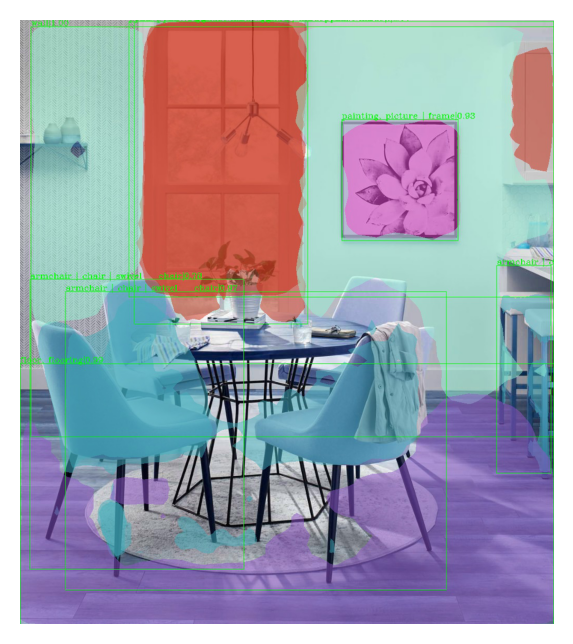

In [31]:
result = inference_detector(model_final, img)
model_final.show_result(img, result, score_thr=0.5, out_file='result.jpg')
inf = read_image('result.jpg')
fig = plt.figure(dpi=200, figsize=(8, 4))
infplot = plt.imshow(inf)
plt.axis("off")
plt.show()

In [32]:
class_dict = {model_final.CLASSES[i]:i for i in range(len(model_final.CLASSES))}
print(class_dict)
labels, bboxes, segm_result = segm_detail(img, result, model_final)
segms = mmcv.concat_list(segm_result)

# filter segmentation results by confidence level
inds = np.where(bboxes[:, -1] > 0.5)[0]

# # rank segmentation by confidence level
arg_sort = np.argsort(-bboxes[:, -1])
sorted_inds = [arg for arg in arg_sort if arg in inds]

# obtain segmentaion corresponding to painting/picture frames
picture_segms = [segms[j] for j in sorted_inds if labels[j] == class_dict['painting, picture | frame']]

{'door | doorframe, doorcase | double door': 0, 'bed | bedpost | blanket, cover | headboard': 1, 'wardrobe, closet, press': 2, 'lamp': 3, 'chest of drawers, chest, bureau, dresser | chest': 4, 'pillow': 5, 'armchair | chair | swivel    chair': 6, 'pane, pane of glass, window glass | windowpane, window': 7, 'curtain, drape, drapery, mantle, pall': 8, 'mirror': 9, 'painting, picture | frame': 10, 'wall': 11, 'ceiling': 12, 'floor, flooring': 13, 'cabinet': 14}


### Refine segmentation results

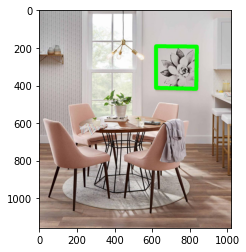

In [33]:
imCopy = img.copy()
for i in range(len(picture_segms)):
    mask = picture_segms[i]
    # obtain raw contours for the segmentation
    contours, hierarchy = cv2.findContours((mask).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # get an approximated contour with only 4 corners
    approx = getApproxCorner(contours[0], coef=0.03, corner=4)
    cv2.drawContours(imCopy, [approx], 0, (0,255,0), 20)
    plt.imshow(imCopy)

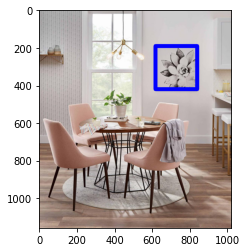

In [34]:
imCopy = img.copy()
for i in range(len(picture_segms)):
    mask = picture_segms[i]
    # obtain raw contours for the segmentation
    contours, hierarchy = cv2.findContours((mask).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # get an approximated minimum area rectangle bounding the contour
    rect = cv2.minAreaRect(contours[0])
    box = cv2.boxPoints(rect) 
    box = np.int0(box)
    cv2.drawContours(imCopy,[box],0,(0,0,255),20)
    plt.imshow(imCopy)

### Another example

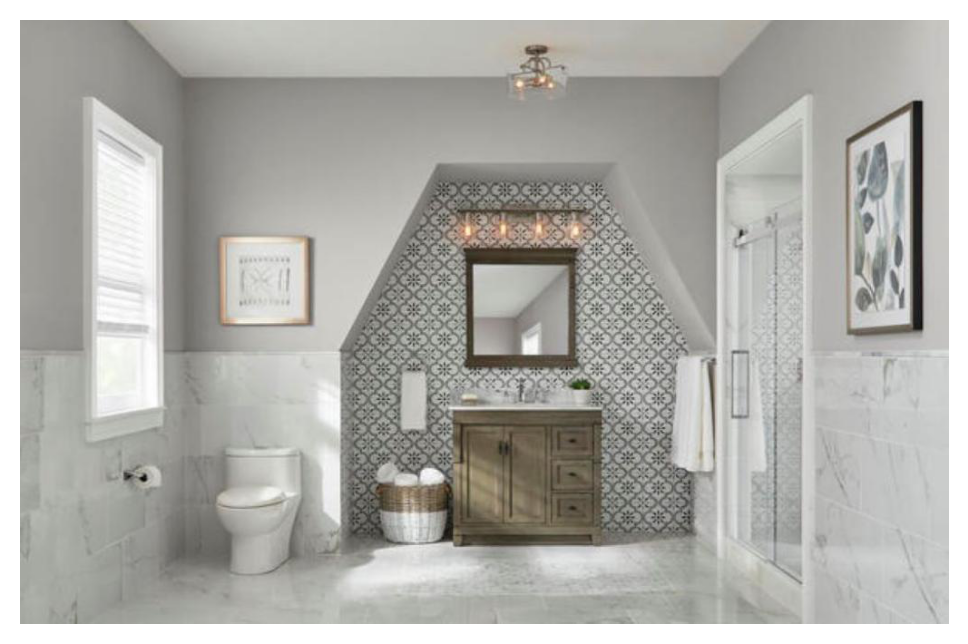

In [35]:
img2 = read_image('https://images.homedepot-static.com/lifestyleimages/1024x682/080654fe-6f08-4c28-8d7f-9e48fed449692.jpeg')
fig2 = plt.figure(dpi=200, figsize=(8, 4))
imgplot2 = plt.imshow(img2)
plt.axis("off")
plt.show()

/usr/local/lib/python3.6/dist-packages/mmcv/utils/misc.py:256: UserWarning: "iou_thr" is deprecated in `nms`, please use "iou_threshold" instead
  f'"{src_arg_name}" is deprecated in '


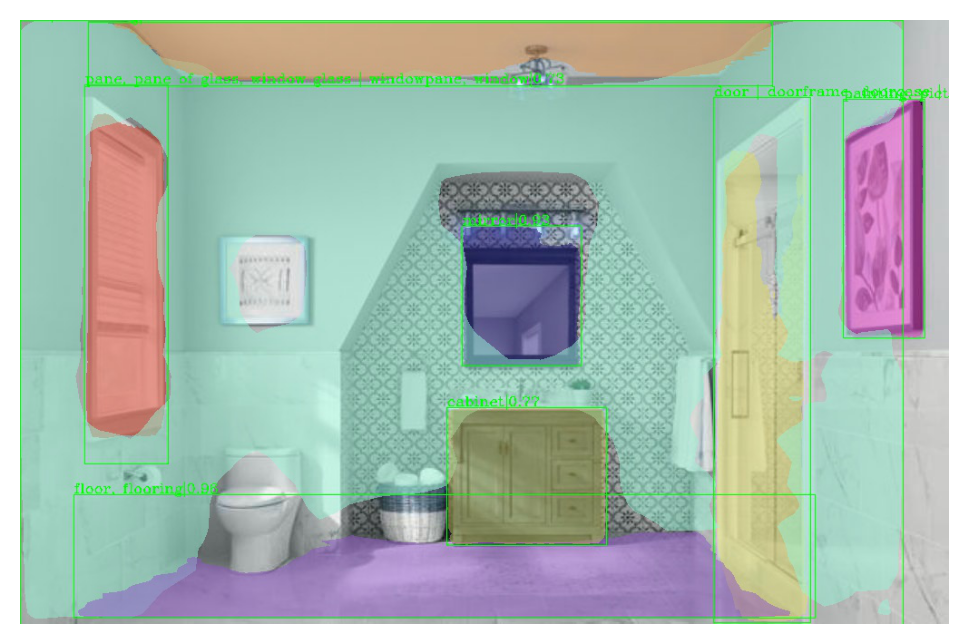

In [36]:
result2 = inference_detector(model_final, img2)
model_final.show_result(img2, result2, score_thr=0.5, out_file='result2.jpg')
inf2 = read_image('result2.jpg')
fig2 = plt.figure(dpi=200, figsize=(8, 4))
infplot2 = plt.imshow(inf2)
plt.axis("off")
plt.show()

In [37]:
labels2, bboxes2, segm_result2 = segm_detail(img2, result2, model)
segms2 = mmcv.concat_list(segm_result2)

# filter segmentation results by confidence level
inds2 = np.where(bboxes2[:, -1] > 0.5)[0]
# # rank segmentation by confidence level
arg_sort2 = np.argsort(-bboxes2[:, -1])
sorted_inds2 = [arg for arg in arg_sort2 if arg in inds2]

# obtain segmentaion corresponding to painting/picture frames
window_segms = [segms2[j] for j in sorted_inds2 if labels2[j] == class_dict['pane, pane of glass, window glass | windowpane, window']]

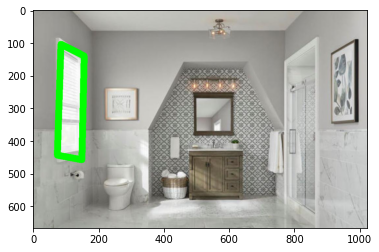

In [38]:
imCopy2 = img2.copy()
for i in range(len(window_segms)):
    mask = window_segms[i]
    # obtain raw contours for the segmentation
    contours, hierarchy = cv2.findContours((mask).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    approx = getApproxCorner(contours[0], coef=0.03, corner=4)
    cv2.drawContours(imCopy2, [approx], 0, (0,255,0), 20)
    plt.imshow(imCopy2)